# <center> The Python Quants Certificate Program on Python for Algorithmic Trading </center>

## <center>Testing out the Pairs trading methodology on the Cryptocurrency market </center>

### <center> Ricky Macharm: ricky.macharm@gmail.com </center>


## =========================================================================

## Abstract
Pairs Trading is a statistical arbitrage strategy that takes advantage of securities that appear to be out
of equilibrium by deploying a mean revertin strategy in prices of thise securities. In this report, I will apply the cointegration and principal component analysis methods to a basket of 36 cryptocurrencies traded on the Binance exchange (and publicly available), specifically the daily frequencies. I will also utilize the  Kalman Filtering for spread prediction, to show if the strategies are profitable in the cryptocurrency market when not accounting for transaction cost. I will conclude by suggesting directions for further research to improve the trading rules.


**Keywords** Cryptocurrencies,  pairs trading, statistical arbitrage, securities, Kalman Filter 

## Introduction

In 2008, a presumed pseudonymous person or persons authored a bitcoin white paper [Nakamoto, 2008] which gave rise to crytocurrencies which are a form of electronic cash. Cryptocurrencies can be traded much in the same way as other securities; albeit with some specific differences like the crypto market trading continuously with no weekends.  

 Being the new kids on the block of investments, it is very obvious to anyone that forming a profitable investment portfolio including cryptocurrencies is novel for most market participants. Al-Yahyaee et al (2018) found that Bitcoin markets are more inefficient than the stock or forex markets, indicating that trading might have an even greater potential to be profitable here than any other.

Andrianto and Diputra (2017) analyzed three cryptocurrencies together with
other traditional assets like  foreign currencies, commodities and stocks and discovered that the chosen cryptocurrencies could increase portfolio efficiency in part by lowering portfolio variance. Bouri et al. (2017) on the other hand, observed the performance of a portfolio included with Bitcoin and cryptocurrencies was found to be a poor hedge; and its hedging and safe haven properties vary over time.

Lee et al. (2018) however seemed to produce empirical evidence to consider ryptocurrencies as a good investment choice to help investors diversify their portfolio risks. This due to the fact that there is a very low correlation between most cryptocurrencies and traditional assets; and it is also a known fact that the average daily return of most cryptocurrencies is higher than that of traditional investments.

Pairs trading can be seen as a sort of mean-reversion contrarian trading strategy that tries to find a long-run equilibrium state between prices of two securities (called pairs), and if the prices of the pair diverge far enough in the short run, a short is initiated in the higher-priced asset while the lower priced asset is bought, leading to profit if and only if the price spread returns to its long-run equilibrium status. This strategy was first shown to be highly profitable in US equities by Gatev et al. 

Interest in pairs trading seems to be declining as observed by Rad et al (2015) that its returns have substantially decreased in recent years. Fil and Kristoufek (2020) applied
the distance and cointegration methods on high-frequency data of a basket of 26 liquid cryptocurrencies and discovered that higher frequency trading (of 1-minute) delivers significantly better performance than others. Since these results are based on a relatively small sample period (January 2018 to September 2019) I want to test that on more data since more time has passed since then on the daily data and also on a wider range of cyptocurrencies. Also I intend to test my data using the in-sample and out-sample method where I choose the best cointegrating pairs and then the best performing of those pairs in-sample before testing them out-sample to see if my performance is any good on the daily data.




## Importing libraries

In [3]:
import numpy as np
import pandas as pd

import quantstats as qs

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

from scipy import stats

from pykalman import KalmanFilter

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns; sns.set()
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

from datetime import date, timedelta

pd.plotting.register_matplotlib_converters()

## Methodology

If two time series are cointegrated, there is some linear combination between them that will vary around a mean. At all points in time, the combination between them is related to the same probability distribution. 

 Let's say we have two variables $x_t$ and $y_t$ that are non-stationary $I(1)$ variables, usually a linear combination of these 2 variables will also be non-stationary, except in a few cases where the linear combination of these variables may be stationary. This happens when the variables share the same stochastic or common trends, which are cancelled out when combined. In these cases, we say that the variables are cointegrated.

We can can represent two time series $x_t$ and $y_t$, thus:
$$ x_t = n_{x_t} + \epsilon_{x_t}$$
$$ y_t = n_{y_t} + \epsilon_{y_t}$$
We can say that both $n_{x_t}$ and $n_{y_t}$ represent the comomn trend components
of the two time series; and $\epsilon_{x_t}$ and $\epsilon_{y_t}$ are the stationary and specific components
Assuming the two series are cointegrated, then their common
trends must be identical such that,
$$ n_{x_t} = \gamma n_{y_t}$$

where $\gamma$ is the cointegration coefficient given by,
$$\gamma = \frac{cov(r_x, r_y)}{var(r_y)}$$

Because the securities drift towards and apart from each other, there will be times when the distance is high and times when the distance is low. The trick of pairs trading comes from maintaining a hedged position across X and Y. If both securities go down, we neither make nor lose money, and likewise if both go up. We make money on the spread of the two reverting to the mean. In order to do this we'll watch for when X and Y are far apart, then short Y and long X. Similarly we'll watch for when they're close together, and long Y and short X.

**Going Long the Spread**

This is when the spread is small and we expect it to become larger. We place a bet on this by longing Y and shorting X.

**Going Short the Spread**

This is when the spread is large and we expect it to become smaller. We place a bet on this by shorting Y and longing X.



## Importing Cryptocurrency Data

In [4]:
path = "data/data.csv"
df = pd.read_csv(path)
df['Time'] = pd.to_datetime(df['Time'])
df.rename(columns = {'Time':'Date'}, inplace = True)
df.set_index('Date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1014 entries, 2019-05-17 to 2022-02-23
Data columns (total 36 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BTCUSDT    1014 non-null   float64
 1   ETHUSDT    1014 non-null   float64
 2   BNBUSDT    1014 non-null   float64
 3   NEOUSDT    1014 non-null   float64
 4   LTCUSDT    1014 non-null   float64
 5   QTUMUSDT   1014 non-null   float64
 6   ADAUSDT    1014 non-null   float64
 7   XRPUSDT    1014 non-null   float64
 8   EOSUSDT    1014 non-null   float64
 9   IOTAUSDT   1014 non-null   float64
 10  XLMUSDT    1014 non-null   float64
 11  ONTUSDT    1014 non-null   float64
 12  TRXUSDT    1014 non-null   float64
 13  ETCUSDT    1014 non-null   float64
 14  ICXUSDT    1014 non-null   float64
 15  NULSUSDT   1014 non-null   float64
 16  VETUSDT    1014 non-null   float64
 17  LINKUSDT   1014 non-null   float64
 18  WAVESUSDT  1014 non-null   float64
 19  ONGUSDT    1014 non-null   flo

In [5]:
tickers = list(df.columns)
print(tickers)
len(tickers)

['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'NEOUSDT', 'LTCUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'IOTAUSDT', 'XLMUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'NULSUSDT', 'VETUSDT', 'LINKUSDT', 'WAVESUSDT', 'ONGUSDT', 'HOTUSDT', 'ZILUSDT', 'ZRXUSDT', 'FETUSDT', 'BATUSDT', 'XMRUSDT', 'ZECUSDT', 'IOSTUSDT', 'CELRUSDT', 'DASHUSDT', 'OMGUSDT', 'THETAUSDT', 'ENJUSDT', 'MITHUSDT', 'MATICUSDT', 'ATOMUSDT']


36

### Testing for Cointegration

The steps in the cointegration test procdure:

1. I will test for a unit root in each component series $y_{t}$ individually.
2. If the unit root cannot be rejected, then the next step is to test cointegration among the components, i.e., to test whether $\alpha Y_{t}$ is I(0).

If I find that the time series as a unit root, then I will move on to the cointegration process. 

Let's consider the regression model for $y_{t}$:

$$y_{1t} = \delta D_{t} + \phi_{1t}y_{2t} + \phi_{m-1} y_{mt} + \varepsilon_{t} $$

$D_{t}$ is the deterministic term. From there, we can test whether $\varepsilon_{t}$ is $I(1)$ or $I(0)$. The hypothesis test is as follows:

$$
\begin{aligned}
H_{0} & :  \varepsilon_{t} \sim I(1) \implies y_{t} \ (no \ cointegration)  \\
H_{1} & : \varepsilon_{t} \sim I(0) \implies y_{t} \ (cointegration)  \\
\end{aligned}
$$

$y_{t}$ is cointegrated with a *normalized cointegration vector* $\alpha = (1, \phi_{1}, \ldots,\phi_{m-1}).$

We also use residuals $\varepsilon_{t}$ for unit root test.

$$
\begin{aligned}
H_{0} & :  \lambda = 0 \ (Unit \ Root)  \\
H_{1} & : \lambda < 1 \ (Stationary)  \\
\end{aligned}
$$

This hypothesis test is for the model:

$$\Delta\varepsilon_{t}=\lambda\varepsilon_{t-1}+\sum^{p-1}_{j=1}\varphi\Delta\varepsilon_{t-j}+\alpha_{t}$$

The test statistic for the following equation:

$$t_{\lambda}=\frac{\hat{\lambda}}{s_{\hat{\lambda}}} $$



## In-sample and Out-sample

I will divide my data into in-sample and out-sample. I will use the in sample to determing the best cointegrated pairs then run a backtest to see the pairs that give the best CAGR. After selecting this final pairs, I will use that to run an out-samle backtest then compare the final results with a BTCUSD benchmark.

In [6]:
df2 = df.iloc[-500:,]
df1 = df.iloc[:-500,]

In [7]:
def cointegrated_pairs_selection(data, critical_level = 0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[tickers[i]]
            S2 = data[tickers[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < critical_level:
                pairs.append([tickers[i], tickers[j]])
    return score_matrix, pvalue_matrix, pairs

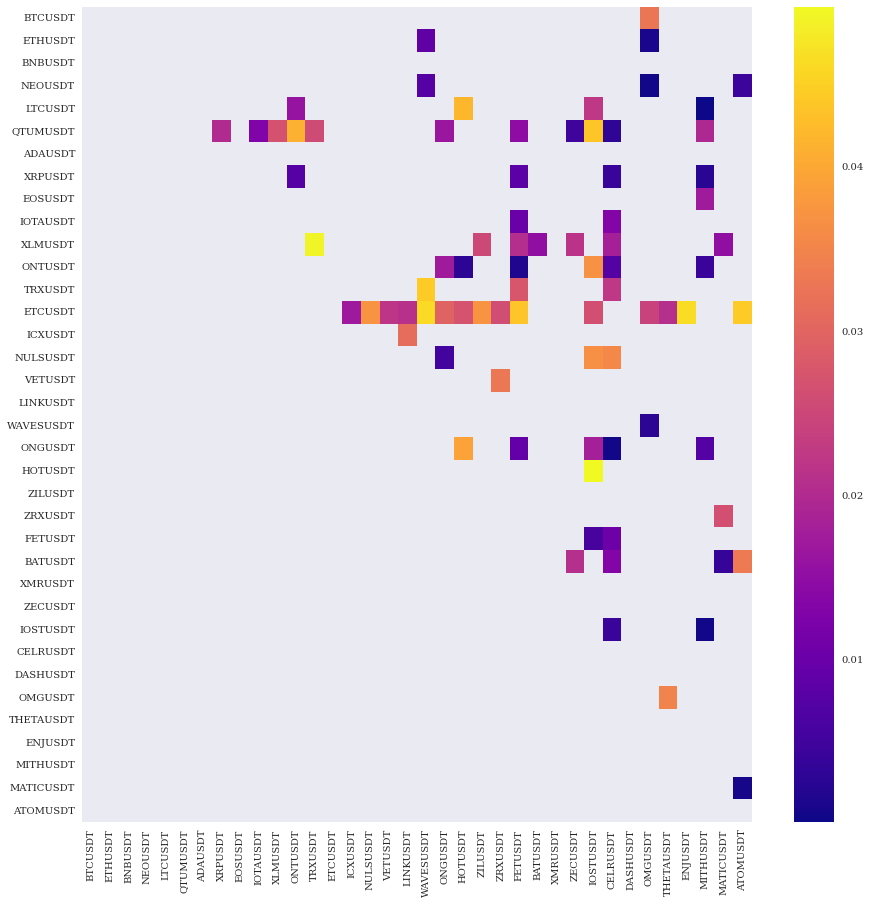

In [8]:
# Heatmap to show the p-values of the cointegration test between each pair of
# crypto currency. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = cointegrated_pairs_selection(df1)

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap="plasma", 
                mask = (pvalues > 0.05)
                );

In [9]:
scores, pvalues, pairs = cointegrated_pairs_selection(df1)
for pair in pairs:
    print(pair)
    

['BTCUSDT', 'OMGUSDT']
['ETHUSDT', 'WAVESUSDT']
['ETHUSDT', 'OMGUSDT']
['NEOUSDT', 'WAVESUSDT']
['NEOUSDT', 'OMGUSDT']
['NEOUSDT', 'ATOMUSDT']
['LTCUSDT', 'ONTUSDT']
['LTCUSDT', 'HOTUSDT']
['LTCUSDT', 'IOSTUSDT']
['LTCUSDT', 'MITHUSDT']
['QTUMUSDT', 'XRPUSDT']
['QTUMUSDT', 'IOTAUSDT']
['QTUMUSDT', 'XLMUSDT']
['QTUMUSDT', 'ONTUSDT']
['QTUMUSDT', 'TRXUSDT']
['QTUMUSDT', 'ONGUSDT']
['QTUMUSDT', 'FETUSDT']
['QTUMUSDT', 'ZECUSDT']
['QTUMUSDT', 'IOSTUSDT']
['QTUMUSDT', 'CELRUSDT']
['QTUMUSDT', 'MITHUSDT']
['XRPUSDT', 'ONTUSDT']
['XRPUSDT', 'FETUSDT']
['XRPUSDT', 'CELRUSDT']
['XRPUSDT', 'MITHUSDT']
['EOSUSDT', 'MITHUSDT']
['IOTAUSDT', 'FETUSDT']
['IOTAUSDT', 'CELRUSDT']
['XLMUSDT', 'TRXUSDT']
['XLMUSDT', 'ZILUSDT']
['XLMUSDT', 'FETUSDT']
['XLMUSDT', 'BATUSDT']
['XLMUSDT', 'ZECUSDT']
['XLMUSDT', 'CELRUSDT']
['XLMUSDT', 'MATICUSDT']
['ONTUSDT', 'ONGUSDT']
['ONTUSDT', 'HOTUSDT']
['ONTUSDT', 'FETUSDT']
['ONTUSDT', 'IOSTUSDT']
['ONTUSDT', 'CELRUSDT']
['ONTUSDT', 'MITHUSDT']
['TRXUSDT', 'WAVESUSDT'

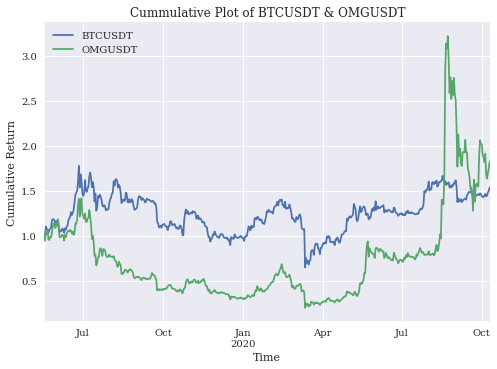

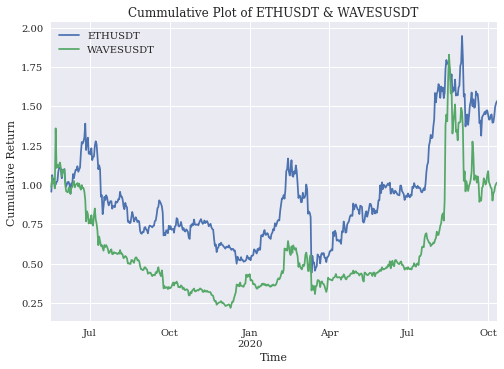

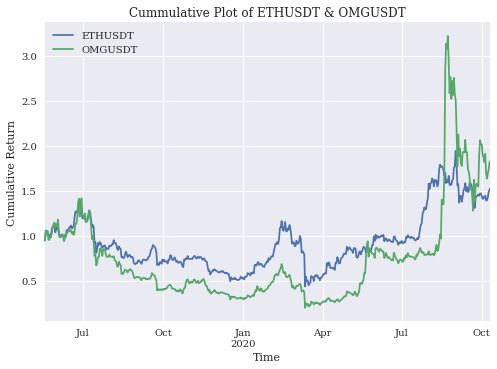

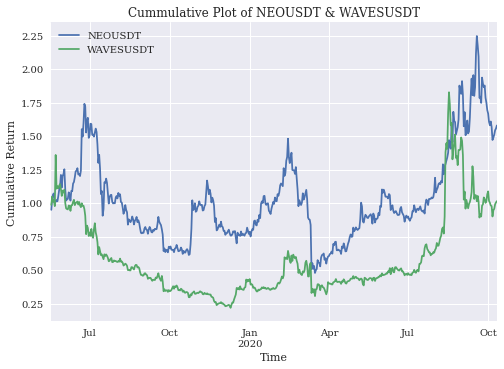

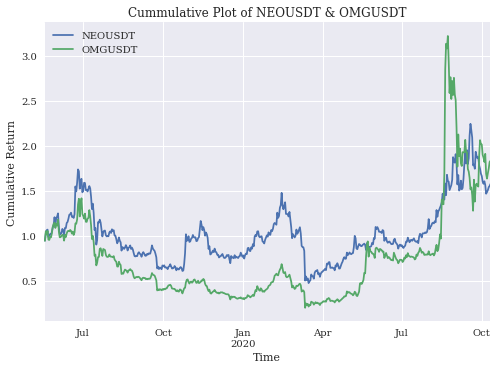

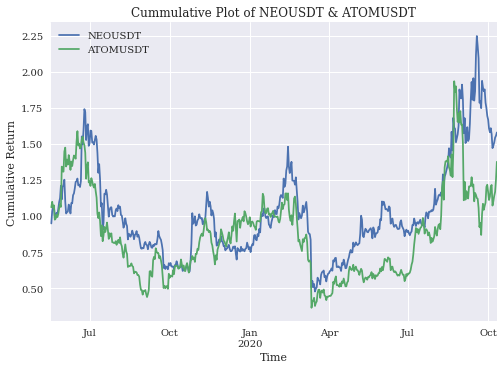

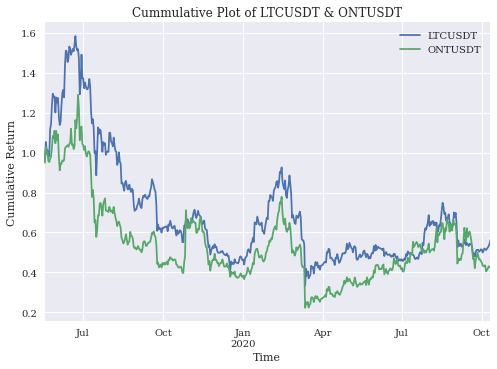

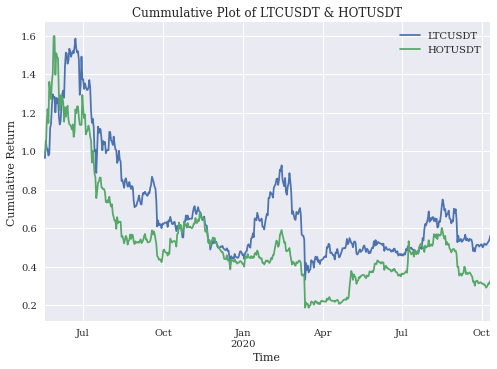

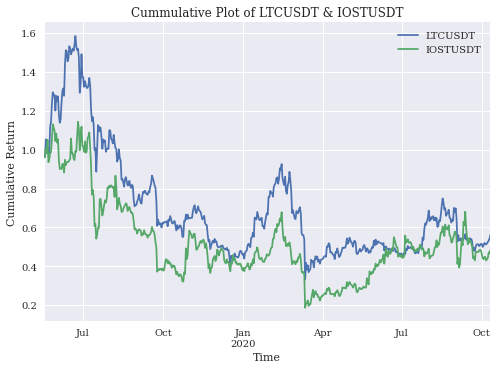

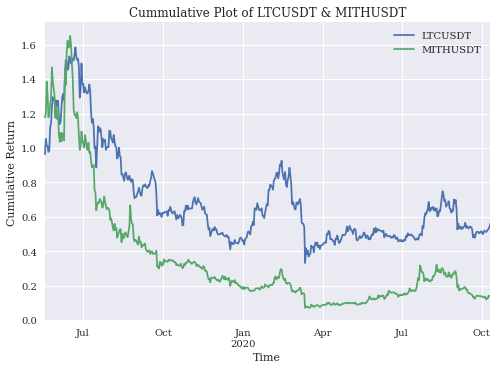

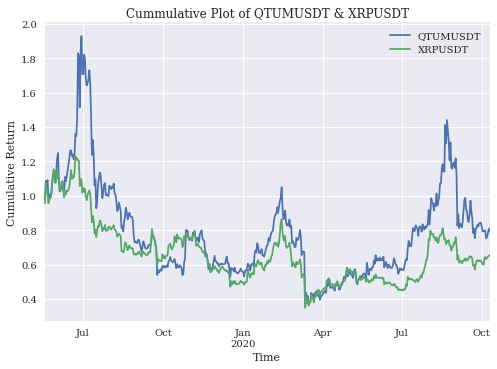

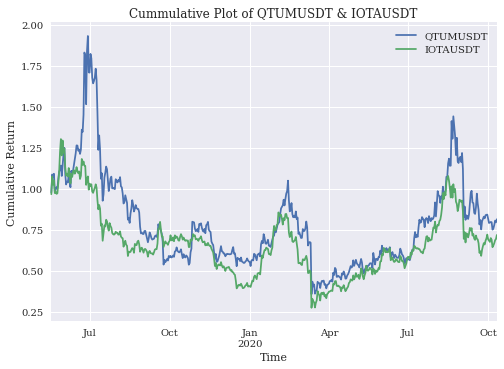

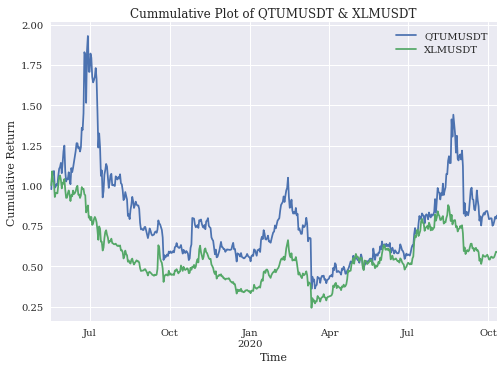

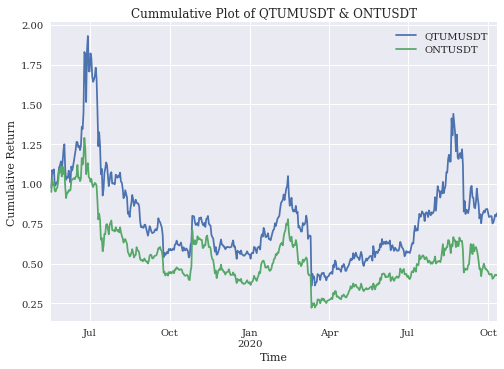

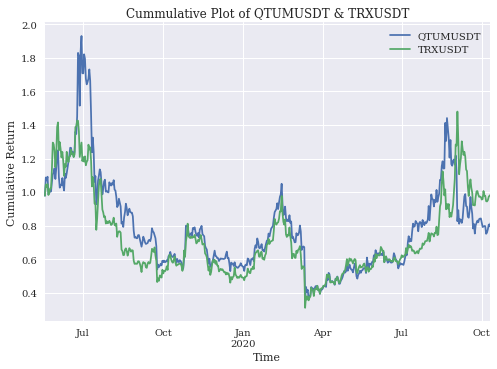

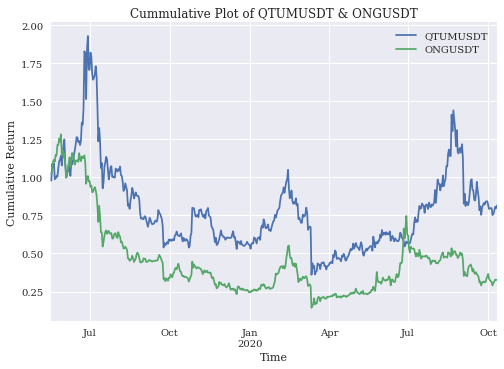

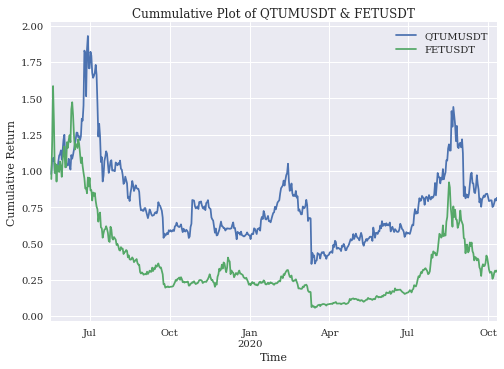

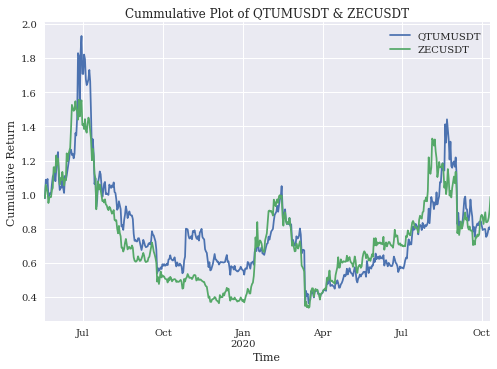

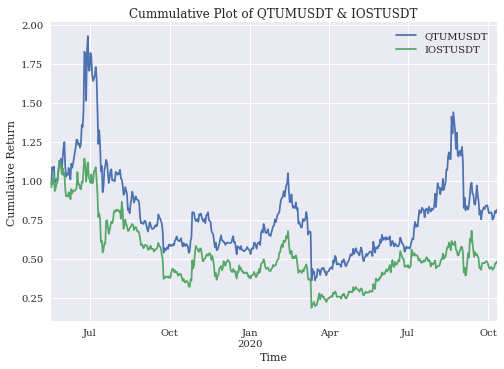

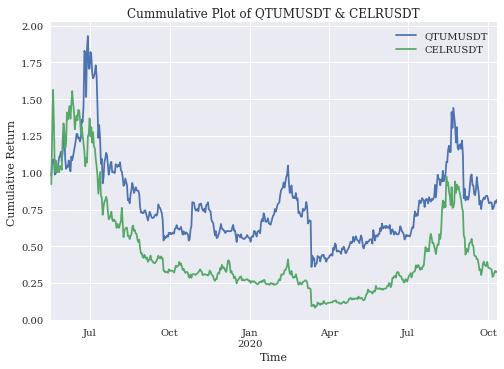

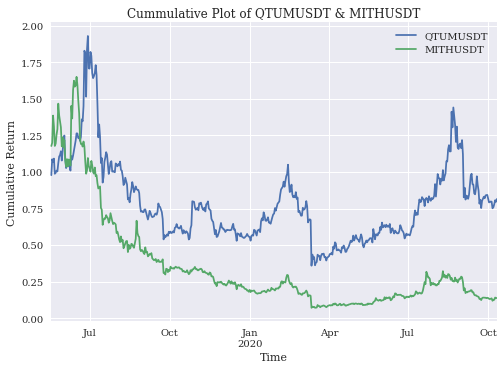

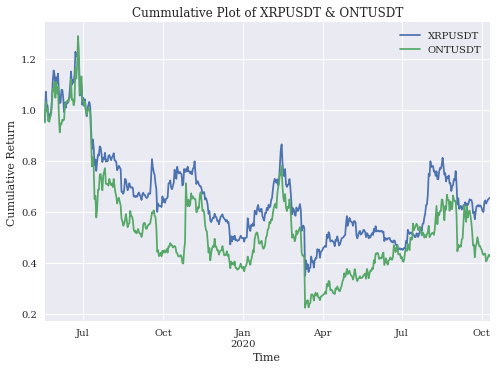

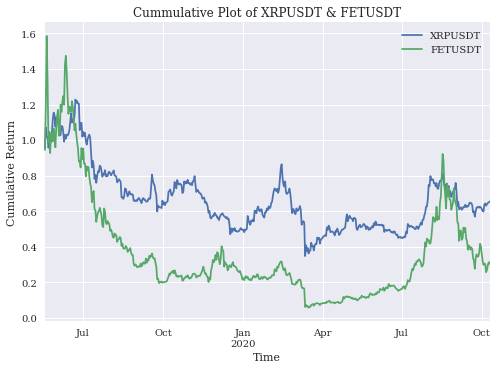

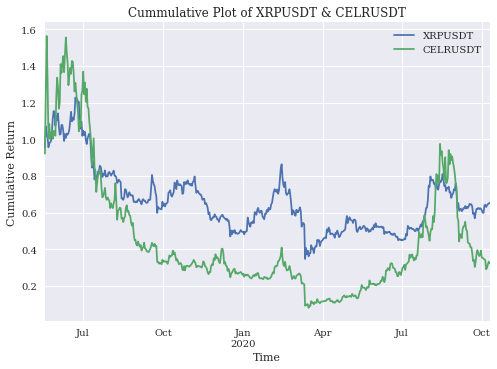

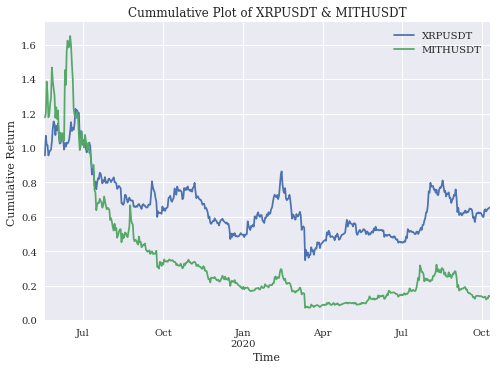

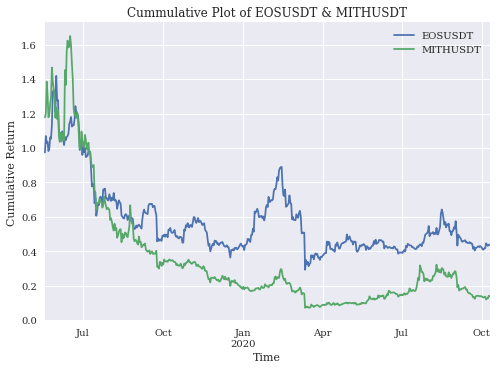

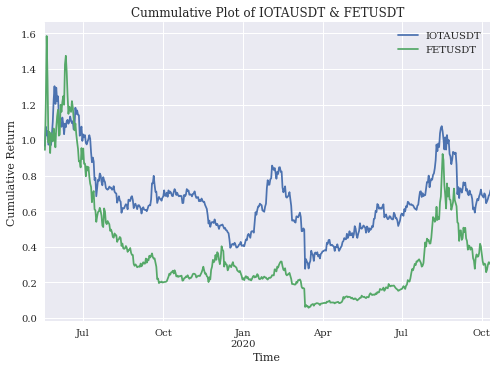

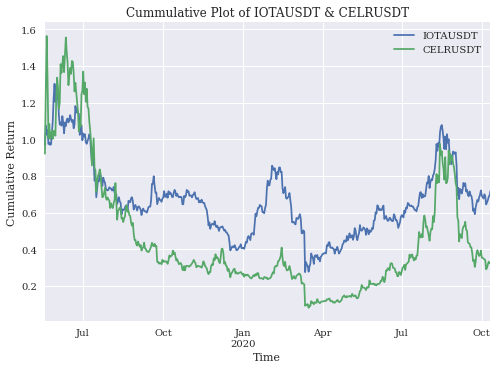

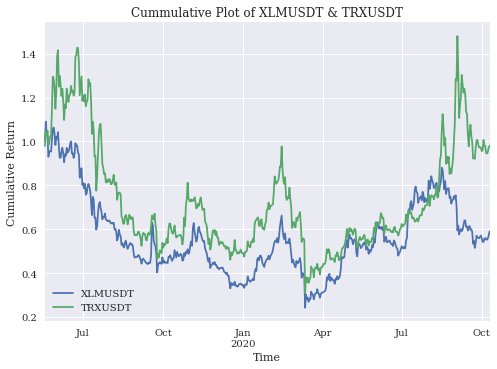

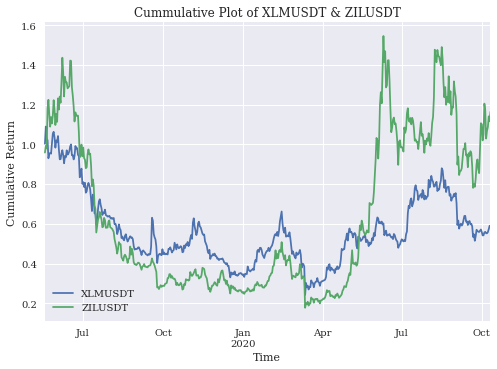

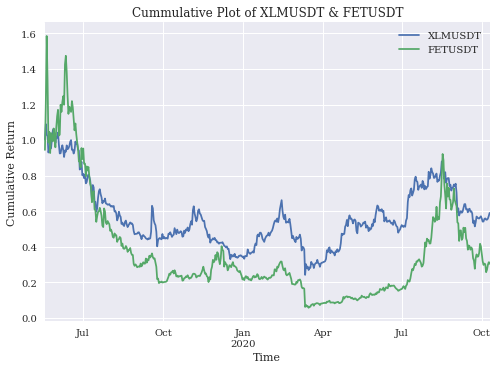

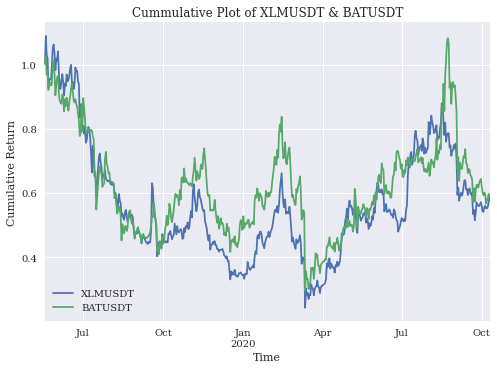

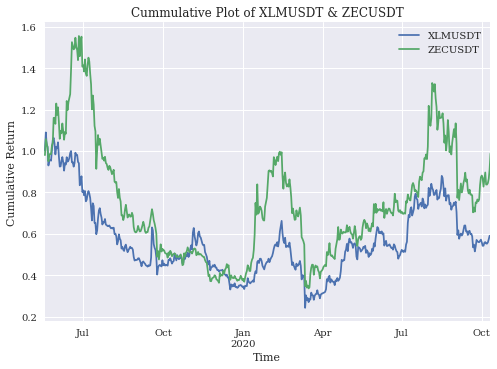

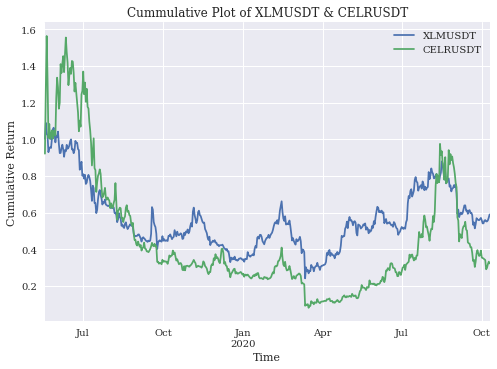

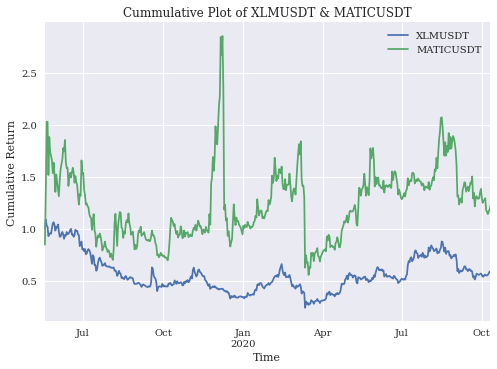

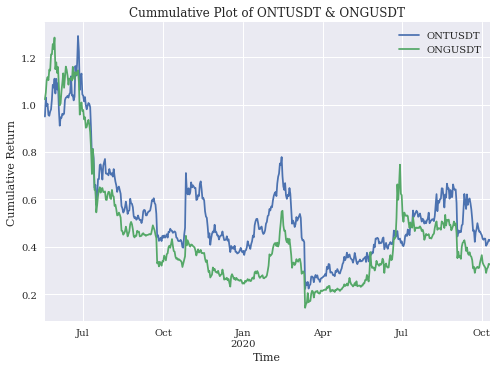

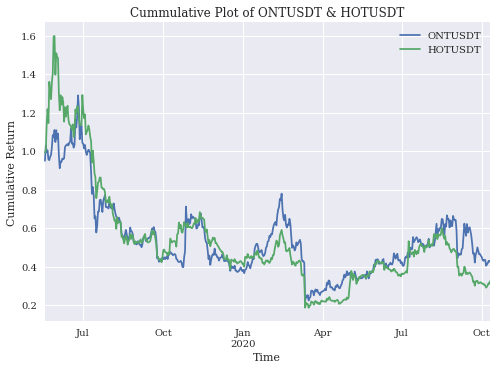

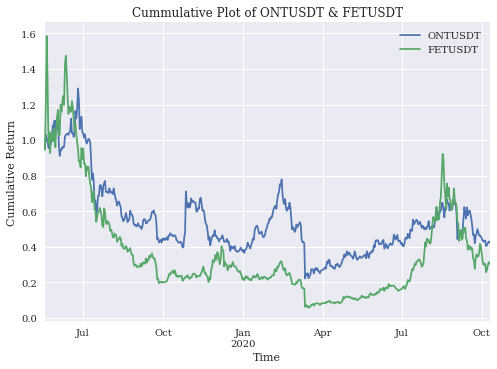

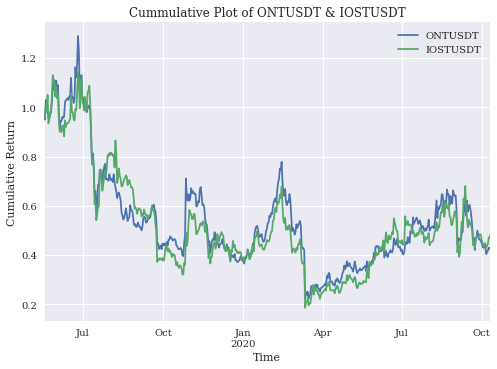

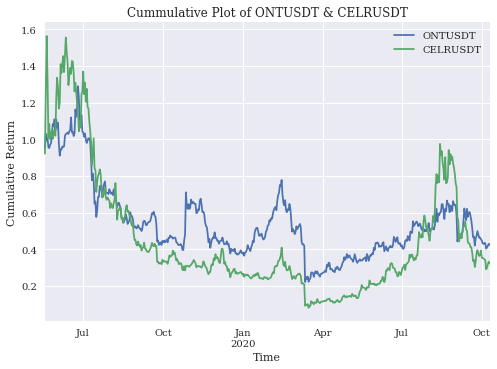

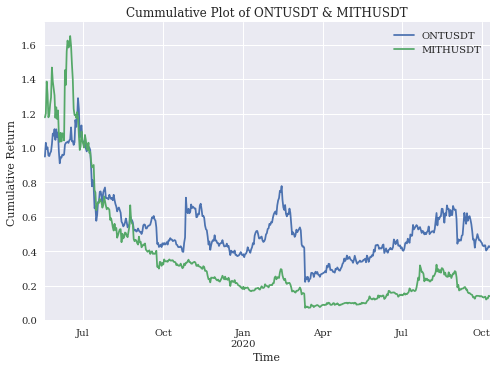

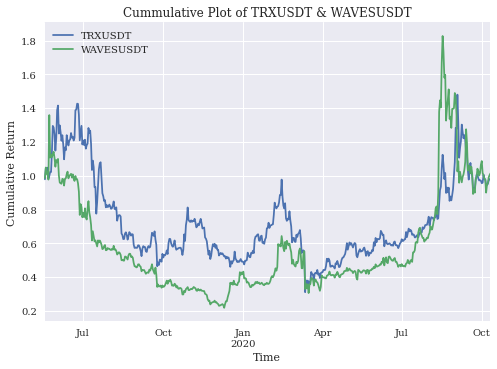

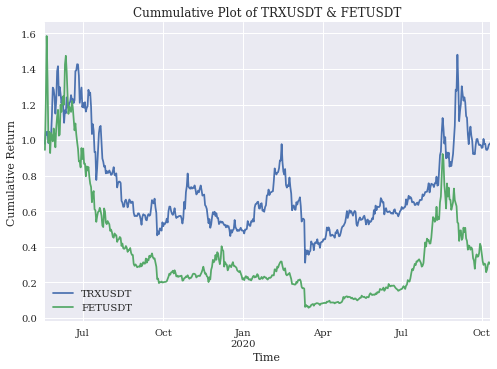

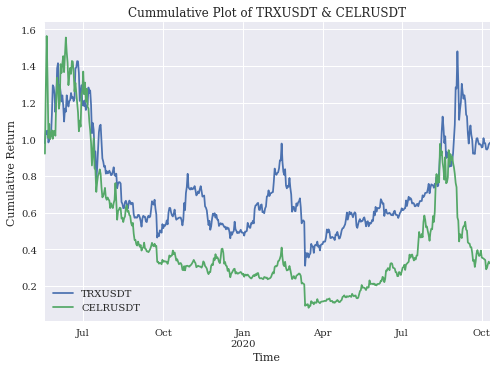

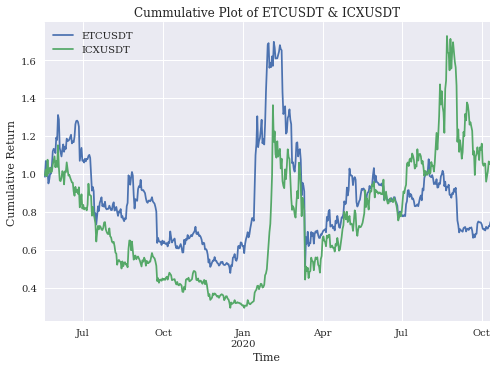

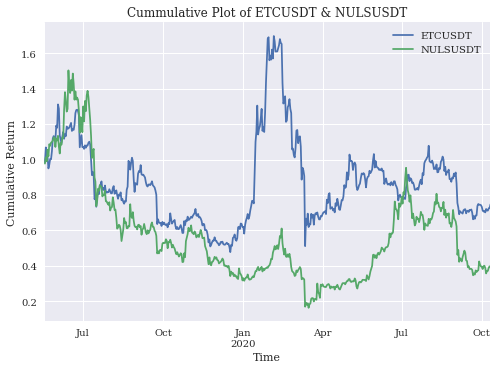

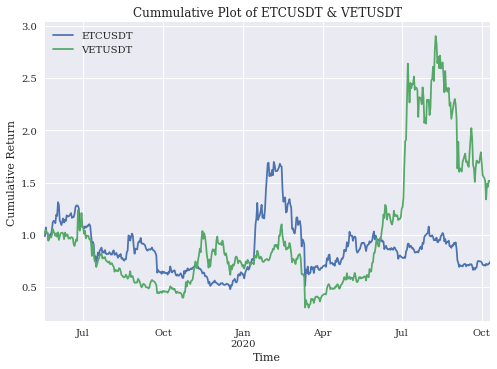

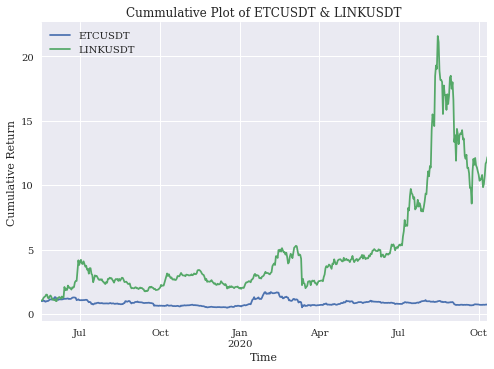

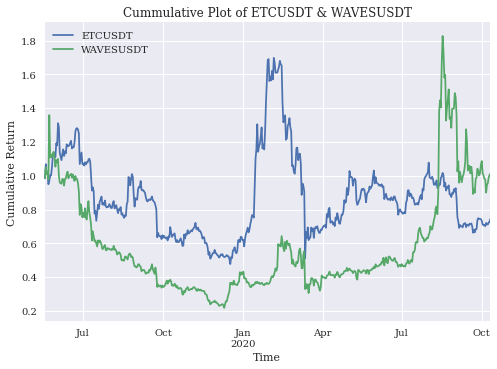

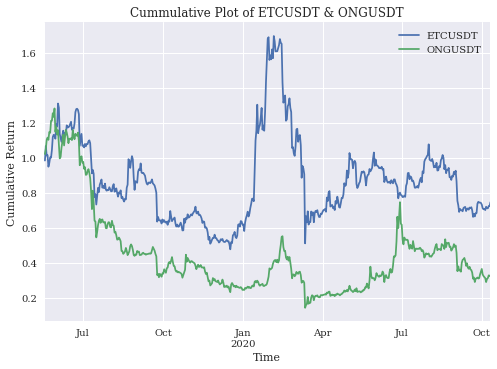

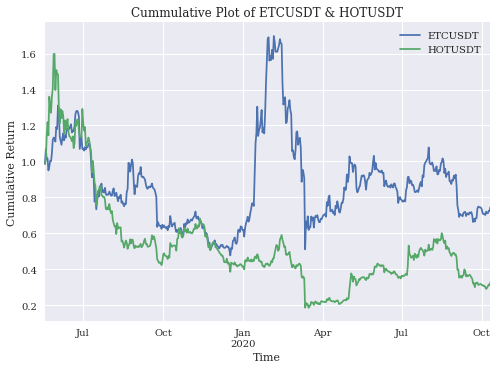

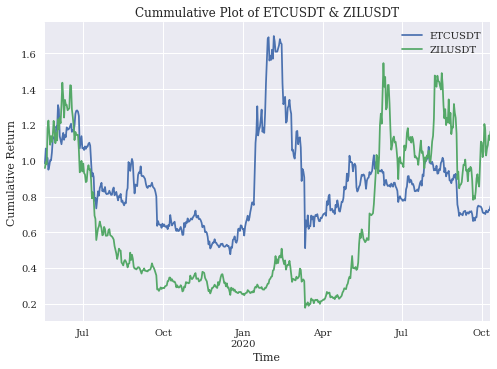

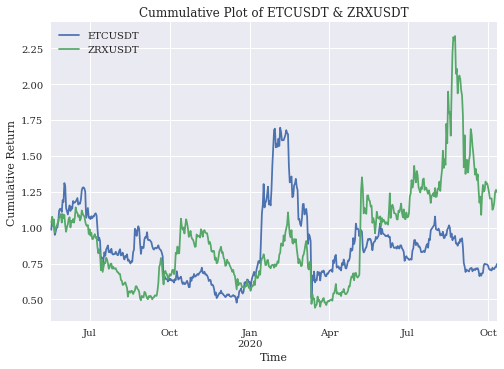

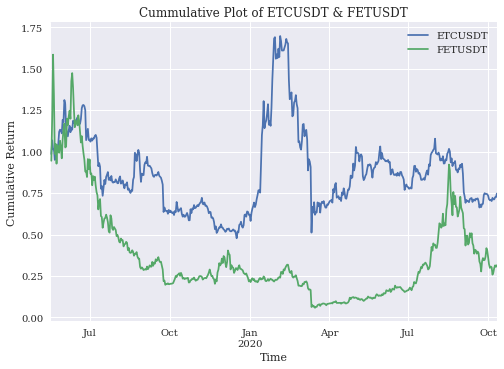

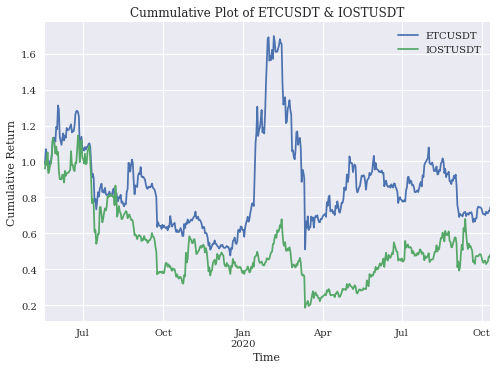

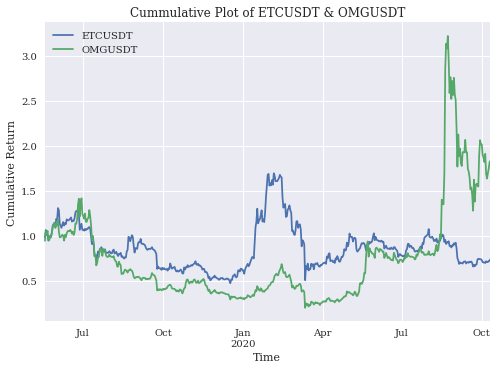

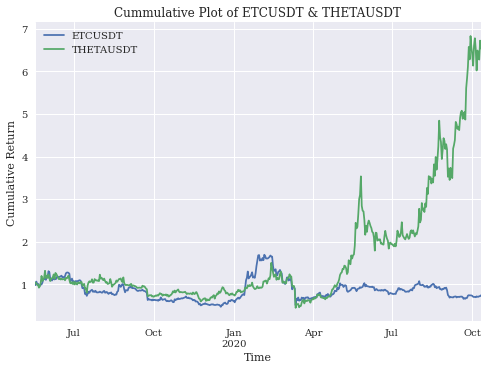

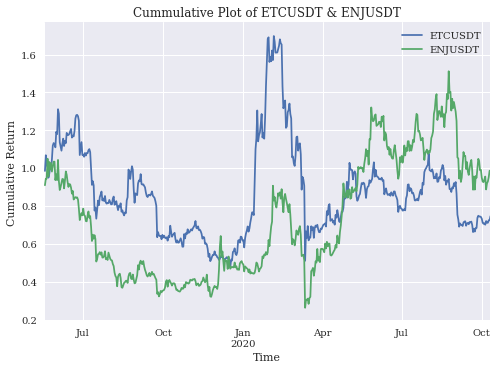

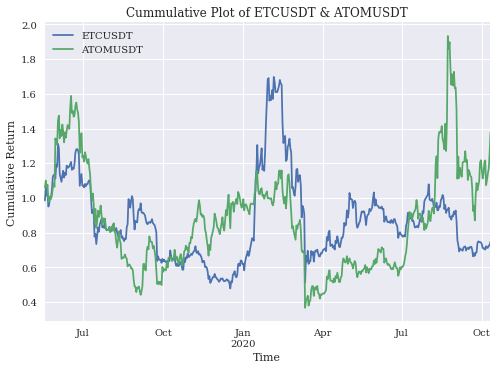

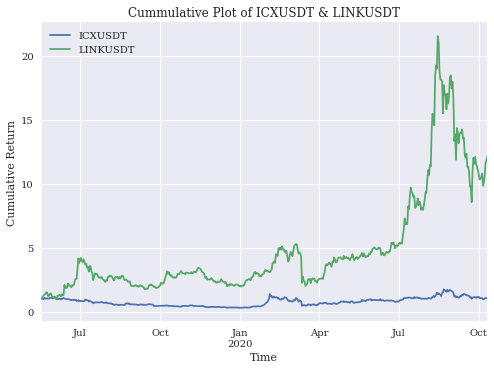

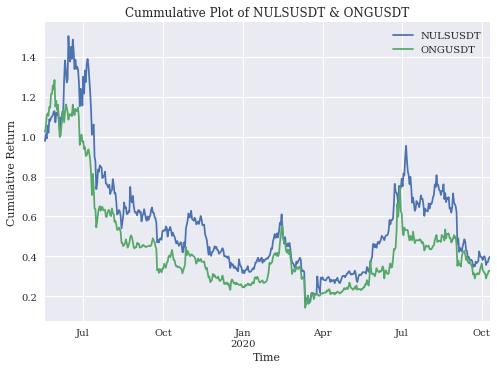

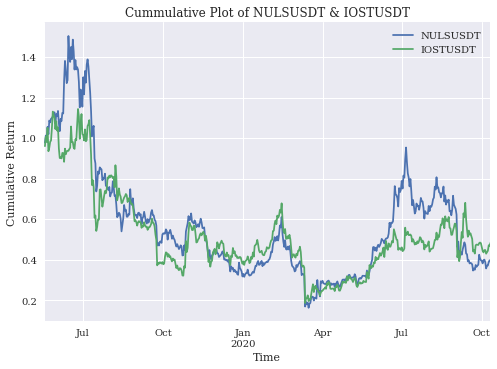

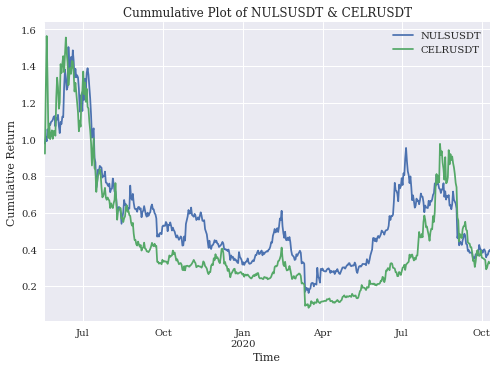

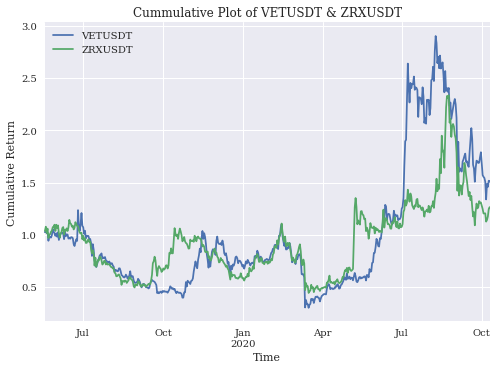

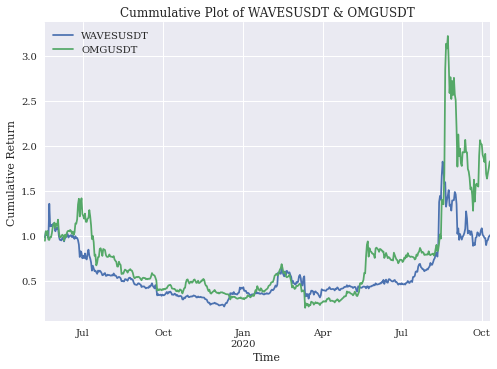

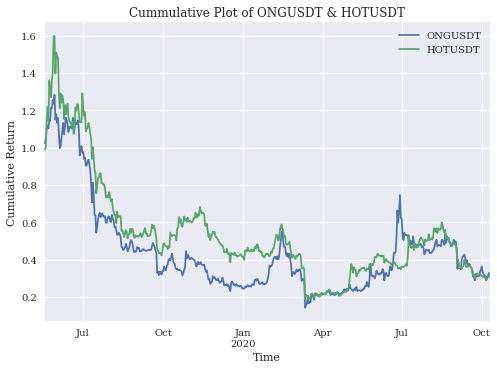

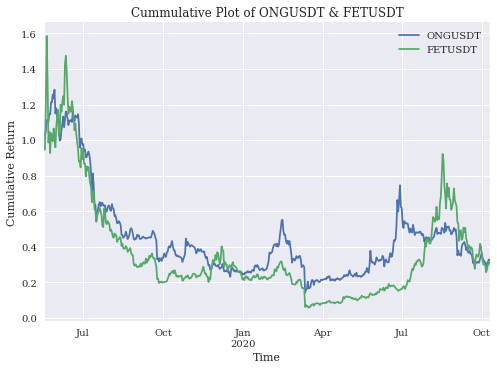

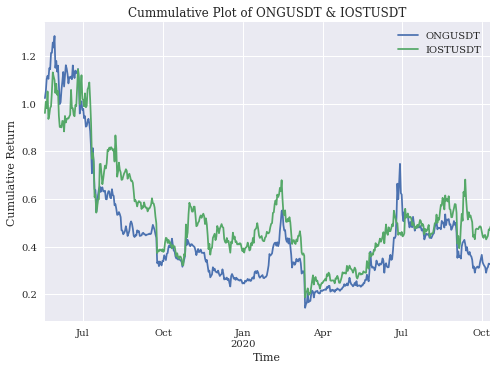

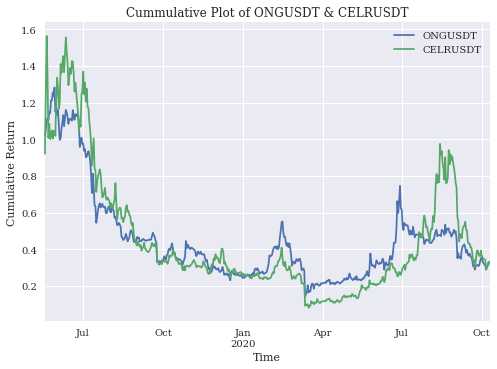

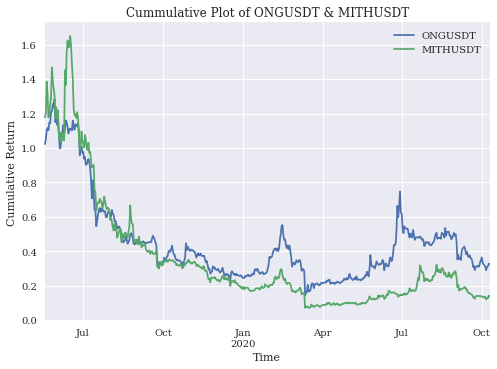

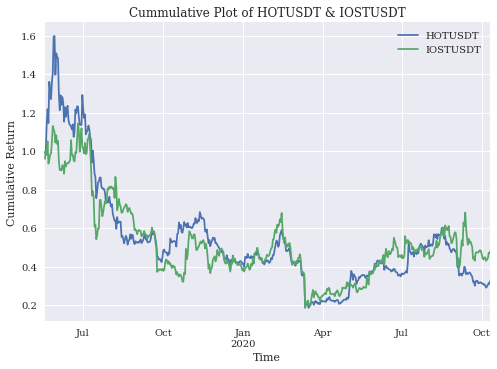

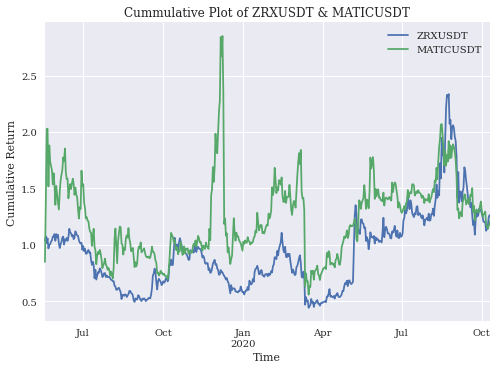

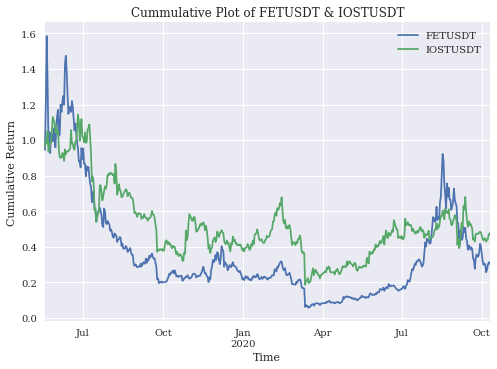

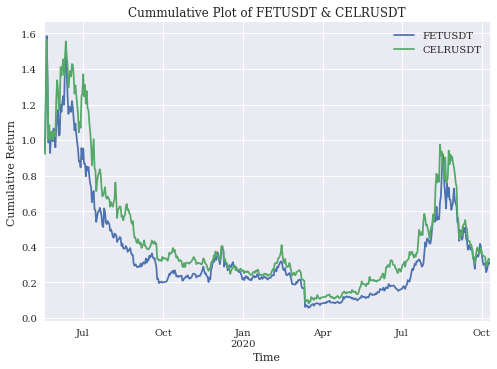

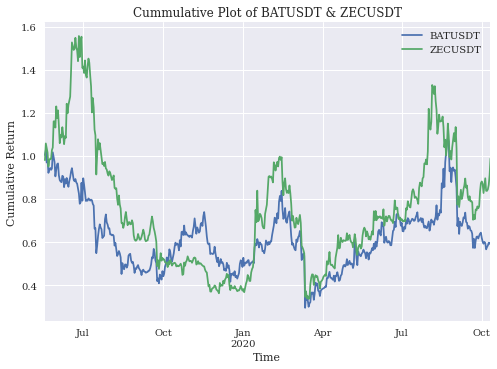

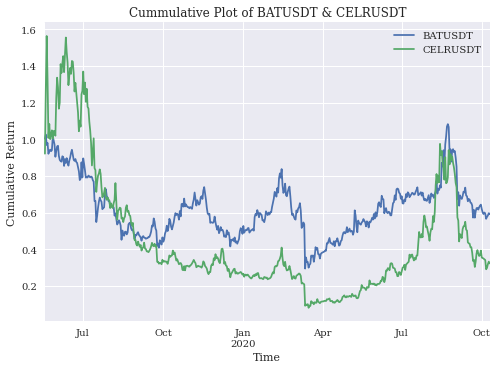

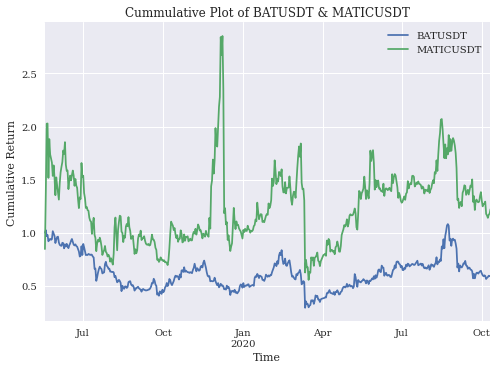

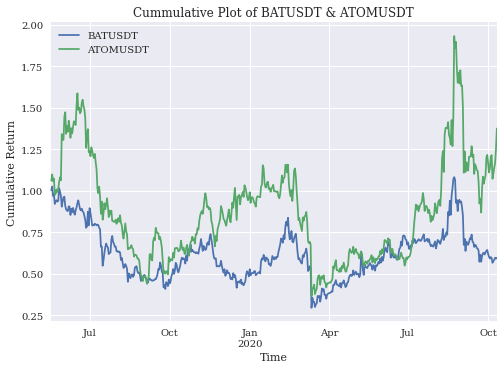

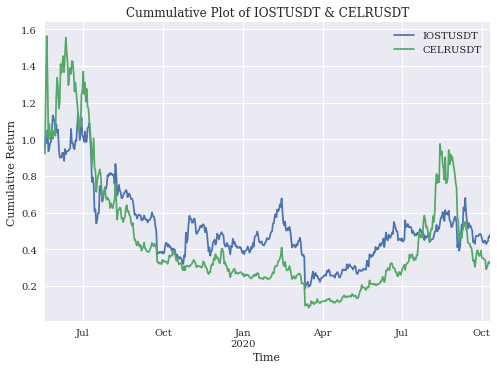

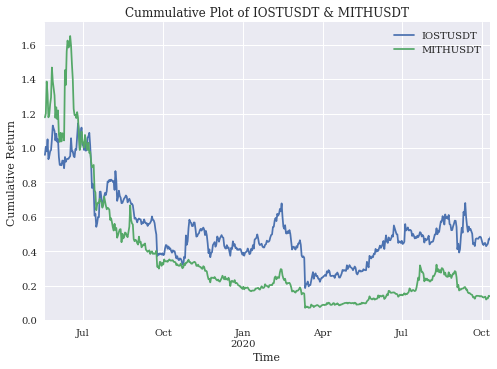

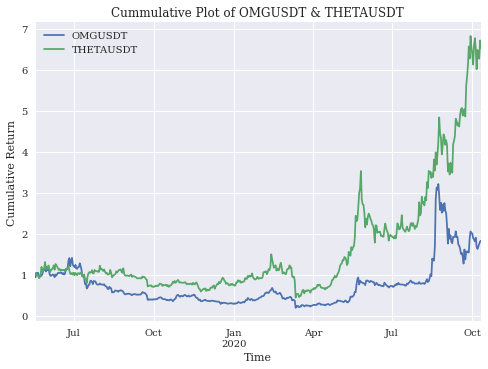

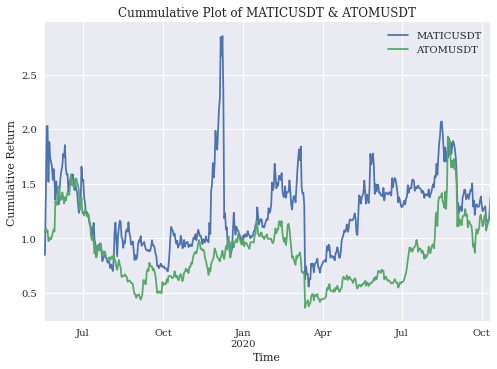

In [10]:
for i in range(len(pairs)):
    pair = df1[pairs[i]]
    cumm_rtn = (1 + pair.pct_change()).cumprod()
    cumm_rtn.plot();
    plt.ylabel('Cumulative Return');
    plt.xlabel('Time');
    plt.title(f'Cummulative Plot of {pair.columns[0]} & {pair.columns[1]}');

From the image plots above, it is obvious to me that there seems to be a little bit of correlation. So I have now decided to apply the principles of pairs trading on them to see what I will get.

They look the same in both case.
We now commence with developing the algorithm.

Time to do some stats. We start off by importing some libraries.

### Testing for Cointegration
What we want to do is to solve for the coefficients $b_1, ... b_k$ that will prodice an $I(0)$ linear combination. If they do not pass the stationarity check then we assume that they are not cointegrated.

We do so by using linear regression to estimate some coefficient $\beta$ such that the relationship below exists: $$ X_2 = \alpha + \beta X_1 + \epsilon $$

From the equation above, it is obvious that $X_2$ depends on $X_1$ in some way and if we could subtract that dependence,  we would have some stationary white noise: $$ X_2 - \beta X_1 = \alpha + \epsilon $$ which should be stationary.


lets get back to code.

## Kalman Filter

In [11]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

Now let us define our main `"Backtest"` function that we will run our data through. The function takes one pair of tickers at a time, and then returns several outputs, namely the DataFrame of cumulative returns, the Sharpe Ratio and the Compound Annual Growth Rate (CAGR). Once we have defined our function, we can iterate over our list of pairs and feed the relevant data, pair by pair, into the function, storing the outputs for each pair for later use and retrieval.

In [12]:
def backtest(df,s1, s2):
    """ 
     INPUT:
     DataFrame of prices (df)
     s1: the symbol of asset one
     s2: the symbol of asset two
     x: the price series of asset one
     y: the price series of asset two
     OUTPUT:
     df1['cum rets']: cumulative returns in pandas data frame
     sharpe: Sharpe ratio
     CAGR: Compound Annual Growth Rate
    """
    
    x = df[s1]
    y = df[s2]
    
    # Run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)
    
    # calculate half life
    halflife = half_life(df1['spread'])
    
    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    
    ##############################################################
    
    # trading logic
    entryZscore = 1.25
    exitZscore = -0.08
    
    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')
    
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
    #set up totals: num units and returns
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    ##############################################################
    
    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
        
    ##############################################################
    
    start_val = 1
    end_val = df1['cum rets'].iat[-1]
    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = (end_val / start_val) ** (365.0/days) - 1
    
    df1[s1+ " "+s2+'_cum_rets'] = df1['cum rets']
    
    return df1[s1+ " "+s2+'_cum_rets'], sharpe, CAGR

In [13]:
results = []
best_pairs = []
selected_pairs = []
for pair in pairs:
    rets, sharpe, CAGR = backtest(df1,pair[0],pair[1])
    results.append(rets)
    print(f"The pair {pair[0]} and {pair[1]} produced a Sharpe Ratio of {sharpe:.2f} and a CAGR of {CAGR:.4f}")
    if  (CAGR >= 0.2) :
        best_pairs.append(f"{pair[0]} {pair[1]}_cum_rets")
        selected_pairs.append([pair[0], pair[1]])
        
    
    
rets0 = pd.concat(results, axis=1)
selected_pairs

The pair BTCUSDT and OMGUSDT produced a Sharpe Ratio of -0.57 and a CAGR of -0.3396
The pair ETHUSDT and WAVESUSDT produced a Sharpe Ratio of 0.93 and a CAGR of 0.3855
The pair ETHUSDT and OMGUSDT produced a Sharpe Ratio of -0.41 and a CAGR of -0.2260
The pair NEOUSDT and WAVESUSDT produced a Sharpe Ratio of 0.03 and a CAGR of 0.0169
The pair NEOUSDT and OMGUSDT produced a Sharpe Ratio of -0.00 and a CAGR of -0.0006
The pair NEOUSDT and ATOMUSDT produced a Sharpe Ratio of 0.54 and a CAGR of 0.2774
The pair LTCUSDT and ONTUSDT produced a Sharpe Ratio of 0.69 and a CAGR of 0.2401
The pair LTCUSDT and HOTUSDT produced a Sharpe Ratio of 1.70 and a CAGR of 0.6041
The pair LTCUSDT and IOSTUSDT produced a Sharpe Ratio of 1.26 and a CAGR of 0.4925
The pair LTCUSDT and MITHUSDT produced a Sharpe Ratio of 1.13 and a CAGR of 0.4933
The pair QTUMUSDT and XRPUSDT produced a Sharpe Ratio of -0.61 and a CAGR of -0.2223
The pair QTUMUSDT and IOTAUSDT produced a Sharpe Ratio of -0.81 and a CAGR of -0.3

[['ETHUSDT', 'WAVESUSDT'],
 ['NEOUSDT', 'ATOMUSDT'],
 ['LTCUSDT', 'ONTUSDT'],
 ['LTCUSDT', 'HOTUSDT'],
 ['LTCUSDT', 'IOSTUSDT'],
 ['LTCUSDT', 'MITHUSDT'],
 ['QTUMUSDT', 'IOSTUSDT'],
 ['EOSUSDT', 'MITHUSDT'],
 ['XLMUSDT', 'ZILUSDT'],
 ['XLMUSDT', 'MATICUSDT'],
 ['ONTUSDT', 'ONGUSDT'],
 ['ONTUSDT', 'IOSTUSDT'],
 ['ETCUSDT', 'ICXUSDT'],
 ['ETCUSDT', 'NULSUSDT'],
 ['ETCUSDT', 'ONGUSDT'],
 ['ETCUSDT', 'ZILUSDT'],
 ['ETCUSDT', 'IOSTUSDT'],
 ['ICXUSDT', 'LINKUSDT'],
 ['NULSUSDT', 'ONGUSDT'],
 ['ONGUSDT', 'IOSTUSDT'],
 ['HOTUSDT', 'IOSTUSDT'],
 ['ZRXUSDT', 'MATICUSDT'],
 ['FETUSDT', 'IOSTUSDT'],
 ['BATUSDT', 'MATICUSDT']]

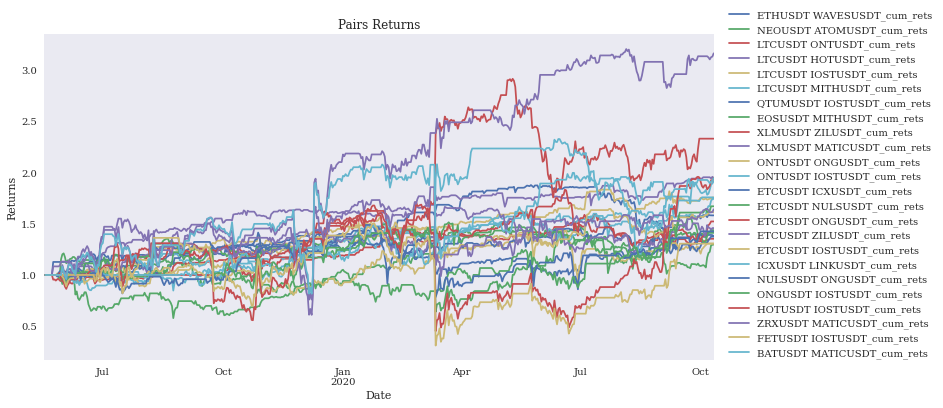

In [14]:
rets0[best_pairs].plot(figsize=(12,6),legend=True)
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.grid(b=None, which=u'major', axis=u'both')
plt.title('Pairs Returns')
plt.xlabel('Date')
plt.ylabel('Returns');

In [15]:
filename = 'data/pairs_rets.csv'
rets0[best_pairs].to_csv(filename)

### out of sample 
We will now apply our pairs trading to our out-sample data to see if we have some profit at the end of the test period.

In [16]:
results2 = []

for pair in selected_pairs:
    rets, sharpe, CAGR = backtest(df2, pair[0], pair[1])
    results2.append(rets)
    print(f"The pair {pair[0]} and {pair[1]} produced a Sharpe Ratio of {sharpe:.2f} and a CAGR of {CAGR:.4f}")
    
        
    
    
rets02 = pd.concat(results2, axis=1)

#concatenate together the individual equity curves into a single DataFrame
results_df = pd.concat(results2,axis=1).dropna()

#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

# square root of sample size for correct number of bins for returns distribution
print('Bin Count =', np.sqrt(len(final_res)))

The pair ETHUSDT and WAVESUSDT produced a Sharpe Ratio of 1.10 and a CAGR of 0.4970
The pair NEOUSDT and ATOMUSDT produced a Sharpe Ratio of 1.96 and a CAGR of 1.0369
The pair LTCUSDT and ONTUSDT produced a Sharpe Ratio of nan and a CAGR of 0.0000
The pair LTCUSDT and HOTUSDT produced a Sharpe Ratio of 0.41 and a CAGR of 0.2918
The pair LTCUSDT and IOSTUSDT produced a Sharpe Ratio of -0.04 and a CAGR of -0.0280
The pair LTCUSDT and MITHUSDT produced a Sharpe Ratio of nan and a CAGR of 0.0000
The pair QTUMUSDT and IOSTUSDT produced a Sharpe Ratio of 0.17 and a CAGR of 0.1364
The pair EOSUSDT and MITHUSDT produced a Sharpe Ratio of 0.24 and a CAGR of 0.2488
The pair XLMUSDT and ZILUSDT produced a Sharpe Ratio of -0.93 and a CAGR of nan
The pair XLMUSDT and MATICUSDT produced a Sharpe Ratio of -0.35 and a CAGR of -0.6609
The pair ONTUSDT and ONGUSDT produced a Sharpe Ratio of 0.74 and a CAGR of 0.8736
The pair ONTUSDT and IOSTUSDT produced a Sharpe Ratio of 0.36 and a CAGR of 0.3159
The p

In [17]:
Pair_Rets = final_res.pct_change()
Pair_Rets = pd.DataFrame(Pair_Rets)
Pair_Rets = Pair_Rets.fillna(0)
Pair_Rets.columns = ['Pairs_Returns']

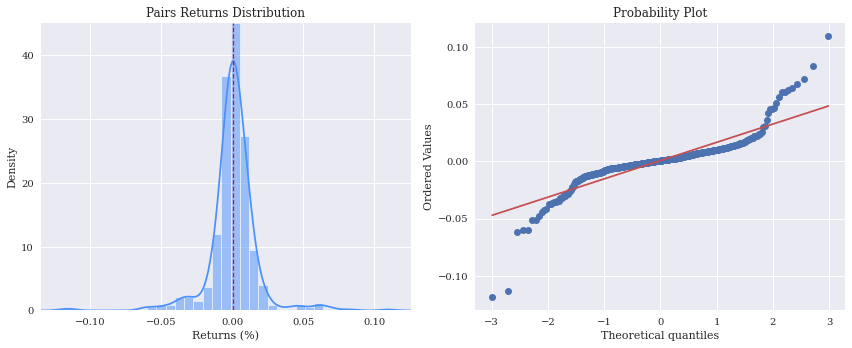

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

sns.distplot(Pair_Rets, hist = True, kde = True, bins=35,
                 hist_kws = {'linewidth': 1, 'alpha':.5},
                 label='Pairs Returns', color='#4b91fa', ax=ax1)

ax1.axvline(x=0.000709, color='#ff0000', linewidth=1.25, linestyle='dashed',label = 'Returns Mean')

ax1.set_title('Pairs Returns Distribution')
ax1.margins(0.001)
ax1.set_xlabel('Returns (%)')
ax1.set_ylabel('Density')

stats.probplot(Pair_Rets.Pairs_Returns, plot=ax2)

plt.tight_layout()

plt.show();

In [19]:
Pair_Rets.Pairs_Returns.describe()

count    499.000000
mean       0.000665
std        0.018000
min       -0.119075
25%       -0.004715
50%        0.000689
75%        0.007074
max        0.109945
Name: Pairs_Returns, dtype: float64

In [20]:
num_pairs = len(results_df.columns)
print('Number of Pairs =', num_pairs)

Number of Pairs = 24


Setting BCT_USD as benchmark

In [22]:
btc_usd = pd.read_csv('data/btc_usd.csv')
btc_usd['Date'] = pd.to_datetime(btc_usd['Date'])

btc_usd.set_index('Date', inplace=True)
btc_usd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2740 entries, 2014-09-17 to 2022-03-18
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   btc_usd  2740 non-null   float64
dtypes: float64(1)
memory usage: 42.8 KB


In [23]:
bench_mark = btc_usd.loc[str(Pair_Rets.index[0]):str(Pair_Rets.index[-1])].pct_change().dropna()
Pair_Rets0 = Pair_Rets.loc[str(bench_mark.index[0]):str(bench_mark.index[-1])]

In [24]:
qs.extend_pandas()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2020-10-14  2020-10-14
End Period                 2022-02-23  2022-02-23
Risk-Free Rate             0.0%        0.0%
Time in Market             99.0%       100.0%

Cumulative Return          28.49%      226.42%
CAGR﹪                     20.21%      138.41%

Sharpe                     0.59        1.26
Prob. Sharpe Ratio         79.34%      96.23%
Smart Sharpe               0.59        1.26
Sortino                    0.83        1.92
Smart Sortino              0.83        1.92
Sortino/√2                 0.59        1.36
Smart Sortino/√2           0.59        1.36
Omega                      1.14        1.14

Max Drawdown               -32.37%     -53.06%
Longest DD Days            271         188
Volatility (ann.)          28.6%       63.33%
R^2                        0.02        0.02
Information Ratio          -0.05       -0.05
Calmar                     0.62    

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2021-01-03  2021-02-21  2021-10-01   271    -32.369467        -29.513331
2  2020-11-23  2020-11-25  2020-11-26     3     -6.167378         -2.527009
3  2020-11-28  2020-12-19  2020-12-24    26     -4.506066         -3.637425
4  2022-01-17  2022-01-22  2022-01-28    11     -2.939097         -1.862353
5  2021-12-14  2021-12-26  2021-12-28    14     -2.732577         -1.587569

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


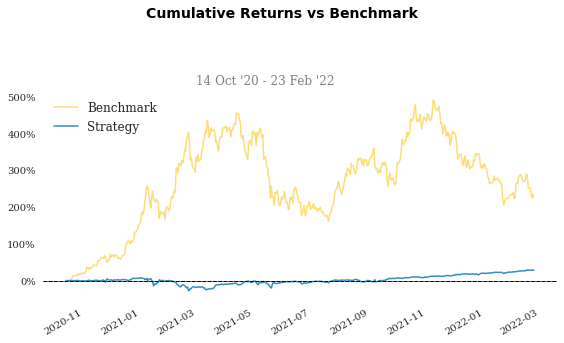

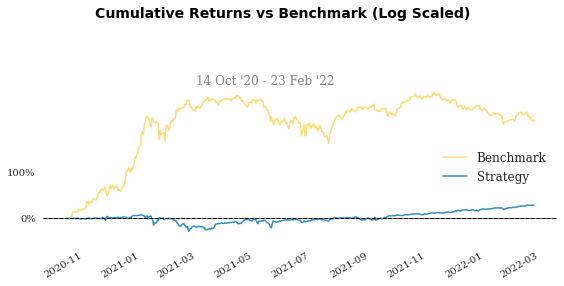

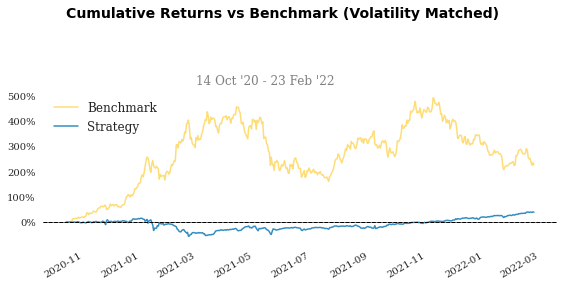

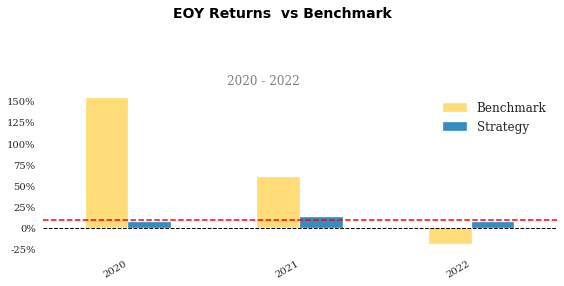

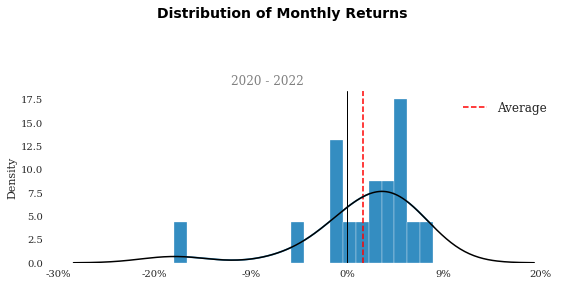

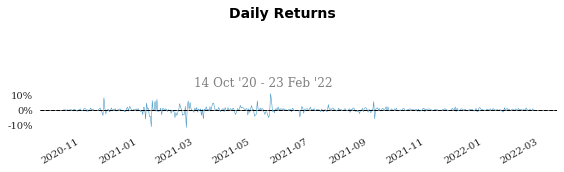

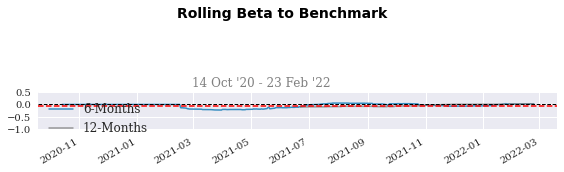

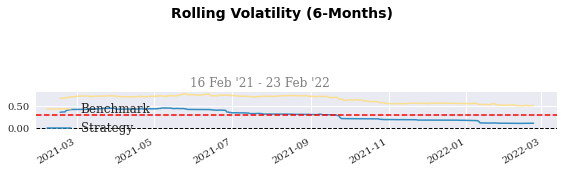

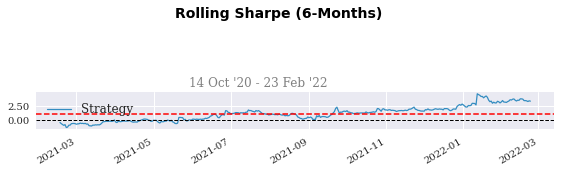

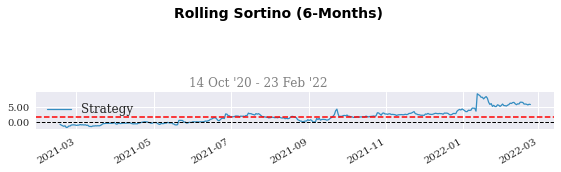

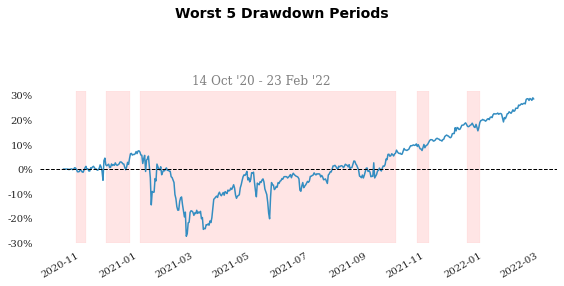

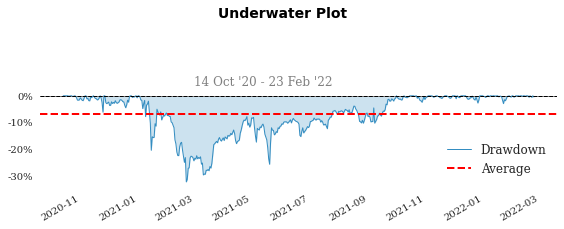

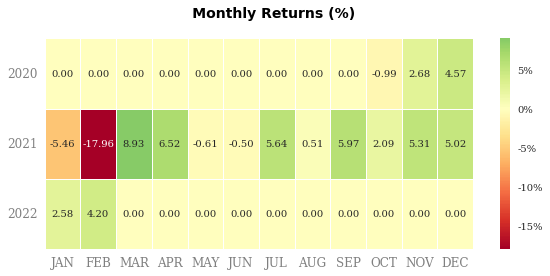

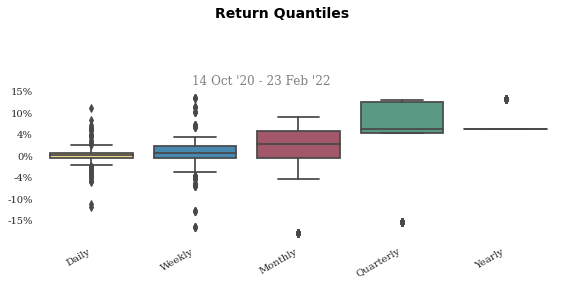

In [25]:
qs.reports.full(Pair_Rets0.Pairs_Returns, bench_mark)

## Conclusion and Further research

What we have here is the fact even though at the end of the test period, we wera able to make some profit (without considering transaction fees which might be high for some of the coins), but it would be best if we just invested in the benchmark (BTCUSD) during that period. The cyrotocurrency market is still evolving and we might need more data for all the coins in the market.

Further research would still be encouraged especially using other methods for selecting pairs to trade (like the distance approach, Time-series, and unspervised learning approaches) and also testing out on other time frames (like 1-minute, 5-minute or 15-minute)


## References
[1] S. Nakamoto, ‘‘Bitcoin: A peer-to-peer electronic cash system,’’ Bit-coin.org, Tech. Rep., Nov. 2008.

K. H. Al-Yahyaee, W. Mensi, and S.-M. Yoon, ‘‘Efficiency, multifractality,and the long-memory property of the bitcoin market: A comparative anal-ysis with stock, currency, and gold markets,’’ Finance Res. Lett., vol. 27,pp. 228–234, Dec. 2018 

[2] E. G. Gatev, W. N. Goetzmann, and K. Geert Rouwenhorst, ‘‘Pairs trad-ing: Performance of a relative value arbitrage rule,’’ National Bureau ofEconomic Research, Cambridge, MA, USA, Tech. Rep. 7032, Mar. 1999. 

[3] H. Rad, R. K. Y. Low, and W. Robert Faff, ‘‘The profitability of Pairstrading strategies: Distance, cointegration, and copula methods,’’ SocialScience Research Network, Rochester, NY, USA, Tech. Rep. 2614233,Jun. 2015 

[4] Fil, M., & Kristoufek, L. (2020).
Pairs trading in cryptocurrency
markets. IEEE Access, 8, 172644-
172651. https://doi.org/10.1109/

[5] Lee, D. K. C., Guo, L., & Wang, Y.
(2018). Cryptocurrency: A new
investment opportunity? Journal
of Alternative Investments, 20(3),
16-40. Retrieved from https://
ink.library.smu.edu.sg/lkcsb_research/5784

[6] Andrianto, Y., & Diputra, Y. (2017).
The effect of cryptocurrency on
investment portfolio effectiveness.
Journal of Finance and Accounting,
5(6), 229-238. http://dx.doi.
org/10.11648/j.jfa.20170506.14

[7] Bouri, E., Molnar, P., Azzi, G.,
Roubaud, D., & Hagfors, L.I.
(2017). On the hedge and safe
haven properties of Bitcoin: Is
it really more than a diversifier?
Finance Research Letters, 20, 192-
198. https://doi.org/10.1016/j.
frl.2016.09.025

[8] Vidyamurthy, Ganapathy. Pairs Trading Quantitative Methods and Analysis. J. Wiley, 2004. 
